In [1]:
import sys
sys.path.append("../")
from inference.ahoy import AHOYv5

ahoy = AHOYv5(model_path="../weights/ahoy-IR.engine")

Loading TensorRT inference engine ../weights/ahoy-IR.engine
 - Input 0: shape (2, 3, 640, 640), dtype float16


In [2]:
from urllib.request import urlopen
import numpy as np
from PIL import Image

url = "https://github.com/SEA-AI/.github/blob/main/assets/example_1_IR.jpg?raw=true"
image = np.array(Image.open(urlopen(url)).convert("RGB"))
image = np.stack([image, image], axis=0)  # stack to simulate batch_size=2
print(image.shape)

ahoy.detect(image, output_mode="tf")
# class -1 is the horizon line where x1, y1, x2, y2 are the coordinates of the horizon end points

(2, 640, 512, 3)


{'detection_boxes': array([[[0.7625    , 0.26972656, 0.7703125 , 0.27792969],
         [0.48388672, 0.32177734, 0.49755859, 0.33007812],
         [0.        , 0.21664186, 0.8       , 0.2520616 ],
         [0.69189453, 0.30029297, 0.70849609, 0.32617188]],
 
        [[0.7625    , 0.26972656, 0.7703125 , 0.27792969],
         [0.48388672, 0.32177734, 0.49755859, 0.33007812],
         [0.        , 0.21664186, 0.8       , 0.2520616 ],
         [0.69189453, 0.30029297, 0.70849609, 0.32617188]]]),
 'detection_scores': array([[0.56396484, 0.55810547, 0.72802734, 0.29816931],
        [0.56396484, 0.55810547, 0.72802734, 0.29816931]]),
 'detection_classes': array([[ 3.,  3.,  2., -1.],
        [ 3.,  3.,  2., -1.]]),
 'num_detections': 2}

 16.3 ms [avg] - preprocess
  5.9 ms [avg] - inference
  3.7 ms [avg] - postprocess
bboxes=array([[543.5 , 258.25, 560.5 , 266.25]]), scores=array([0.86865234]), classes=array([1.]), hor_points=array([[  0.        , 277.86310623, 640.        , 247.61062359]]), hor_score=array([0.31871077])


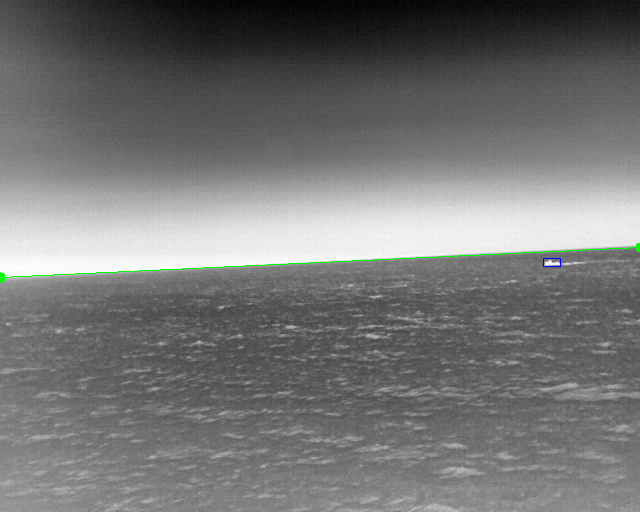

In [3]:
import numpy as np
from PIL import Image
from utils.horizon import draw_horizon, draw_bboxes

image = np.array(Image.open("../examples/example_2_IR.jpg").convert('RGB'))
image = np.stack([image, image], axis=0)  # stack to simulate batch_size=2

ahoy(image, conf_thresh=0.147, iou_thresh=0.1)  # warmup
n = 100
for i in range(n):
    preds = ahoy(image, conf_thresh=0.147, iou_thresh=0.1)[0]

# print average times
for name, profile in ahoy.profiles.items():
    print(f"{profile.t / n * 1E3:>5.1f} ms [avg] - {name}")

bboxes = preds[:, :4] # x1, y1, x2, y2
scores = preds[:, 4] # scores (probabilities)
classes = preds[:, 5] # indices of classes
hor_points, hor_score = bboxes[classes == -1], scores[classes == -1]
bboxes, scores, classes = bboxes[classes != -1], scores[classes != -1], classes[classes != -1]
print(f"{bboxes=}, {scores=}, {classes=}, {hor_points=}, {hor_score=}")

I = image[0]
dets = np.hstack((bboxes, scores[:, np.newaxis], classes[:, np.newaxis]))
I = draw_bboxes(I, dets, color=(0, 0, 255), thickness=1)
I = draw_horizon(I, keypoints=hor_points.reshape(-1, 2), color=(0, 255, 0), diameter=1)
I = Image.fromarray(I)
I  # .reduce(2) if I.width >= 1024 else I